# Machine Learning - XGBoost

In this section, XGBoost is used to forecast the apple prices.

## ⚠️ Disclaimer

> This project is created **for educational and research purposes only**.  
> It does **not** constitute investment advice, financial recommendations, or a solicitation to buy or sell any securities.
>
> All data is sourced from [Yahoo Finance](https://finance.yahoo.com/) using the `yfinance` Python package.  
> This project is **not affiliated with, endorsed by, officially connected to Apple Inc.** or Yahoo Finance in any way. in any way.

In [1]:
#Libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
apple_df = yf.Ticker("AAPL").history(
    start="2020-03-30",
    end="2025-03-29",
    interval="1d"
)
apple_df

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-03-30 00:00:00-04:00,60.849335,62.009340,60.524142,61.837036,167976400,0.0,0.0
2020-03-31 00:00:00-04:00,62.028759,63.700813,61.155113,61.710846,197002000,0.0,0.0
2020-04-01 00:00:00-04:00,59.820381,60.359129,58.031838,58.463806,176218400,0.0,0.0
2020-04-02 00:00:00-04:00,58.325477,59.492763,57.490661,59.439373,165934000,0.0,0.0
2020-04-03 00:00:00-04:00,58.922472,59.626239,57.993010,58.585148,129880000,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-24 00:00:00-04:00,221.000000,221.479996,218.580002,220.729996,44299500,0.0,0.0
2025-03-25 00:00:00-04:00,220.770004,224.100006,220.080002,223.750000,34493600,0.0,0.0
2025-03-26 00:00:00-04:00,223.509995,225.020004,220.470001,221.529999,34466100,0.0,0.0


In [4]:
"""
Similar steps like ML01. Please check ML01_Decision_Tree file to preprocessing part.
"""

#Dividing date to year, month and day columns, and resetting index
apple_df.index = pd.to_datetime(apple_df.index)
apple_df["Day_of_Week"] = apple_df.index.dayofweek
apple_df["Year"] = apple_df.index.year
apple_df["Month"] = apple_df.index.month
apple_df["Day"] = apple_df.index.day
apple_df = apple_df.reset_index(drop=True)
#Shifting High and Low
apple_df["Previous_High"] = apple_df["High"].shift(1)
apple_df["Previous_Low"] = apple_df["Low"].shift(1)
apple_df["Previous_Volume"] = apple_df["Volume"].shift(1)
apple_df.drop(["High", "Low","Volume"], axis=1, inplace=True)
#Creating lags for Close price
for lag in range(1, 62):
    apple_df[f"Close_lag_{lag}"] = apple_df["Close"].shift(lag)
#Getting to moving averages of previous days
apple_df["Previous_MA_5"] = apple_df["Close"].shift(1).rolling(window=5).mean()
apple_df["Previous_MA_20"] = apple_df["Close"].shift(1).rolling(window=20).mean()
apple_df["Previous_MA_ratio"] = apple_df["Previous_MA_5"] / apple_df["Previous_MA_20"]
apple_df.drop(columns=["Dividends","Stock Splits"],inplace=True)
apple_df.dropna(inplace=True)

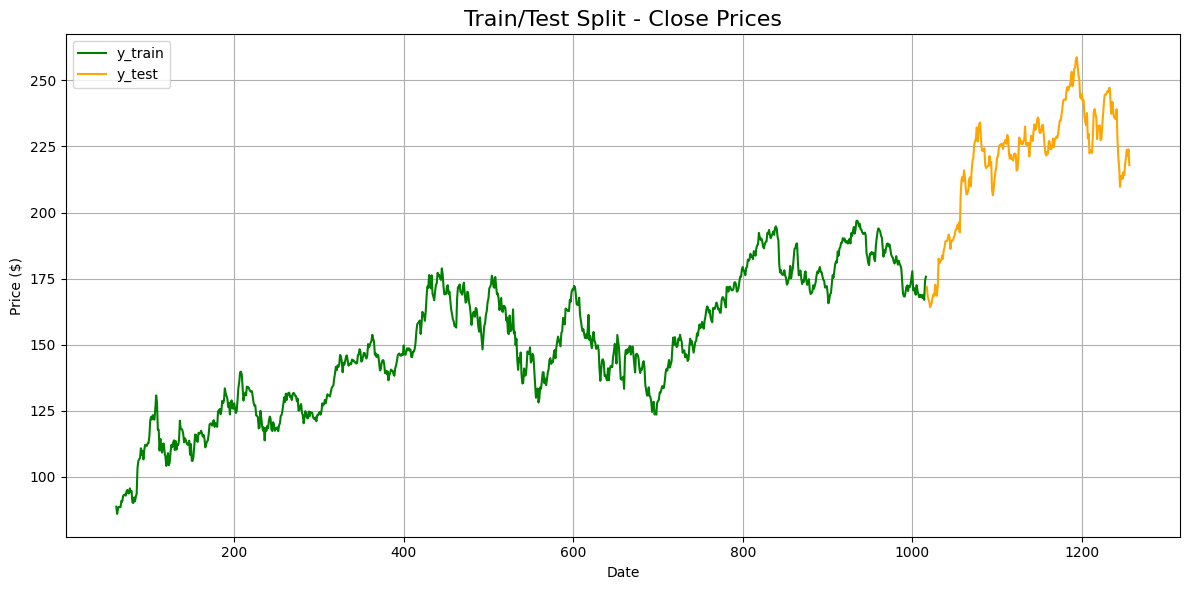

In [5]:
X = apple_df.drop(columns=["Close"])
y = apple_df["Close"]
train_size = int(len(X) * 0.8) # %80 train %20 test
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='y_train', color='green')
plt.plot(y_test.index, y_test, label='y_test', color='orange')
plt.title("Train/Test Split - Close Prices", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# XGBoost

In [8]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import uniform, randint
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score

In [7]:
xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

In [9]:
param_dist = {
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

In [12]:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

In [13]:
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print("Best Params:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Params: {'colsample_bytree': np.float64(0.9552785346302537), 'learning_rate': np.float64(0.29069049826628424), 'max_depth': 6, 'n_estimators': 203, 'subsample': np.float64(0.881928717897877)}


In [14]:
y_pred_decision = best_model.predict(X_test)
y_test = y_test.to_numpy()
r2_dec= r2_score(y_test, y_pred_decision)
rmse_dec = np.sqrt(mean_squared_error(y_test, y_pred_decision))
mape_dec = mean_absolute_percentage_error(y_test, y_pred_decision)
print(f"R^2 is {r2_dec} \n RMSE is {rmse_dec} \n MAPE is {mape_dec}")

R^2 is -1.7345165963081945 
 RMSE is 34.326945699214534 
 MAPE is 0.13067566882238252


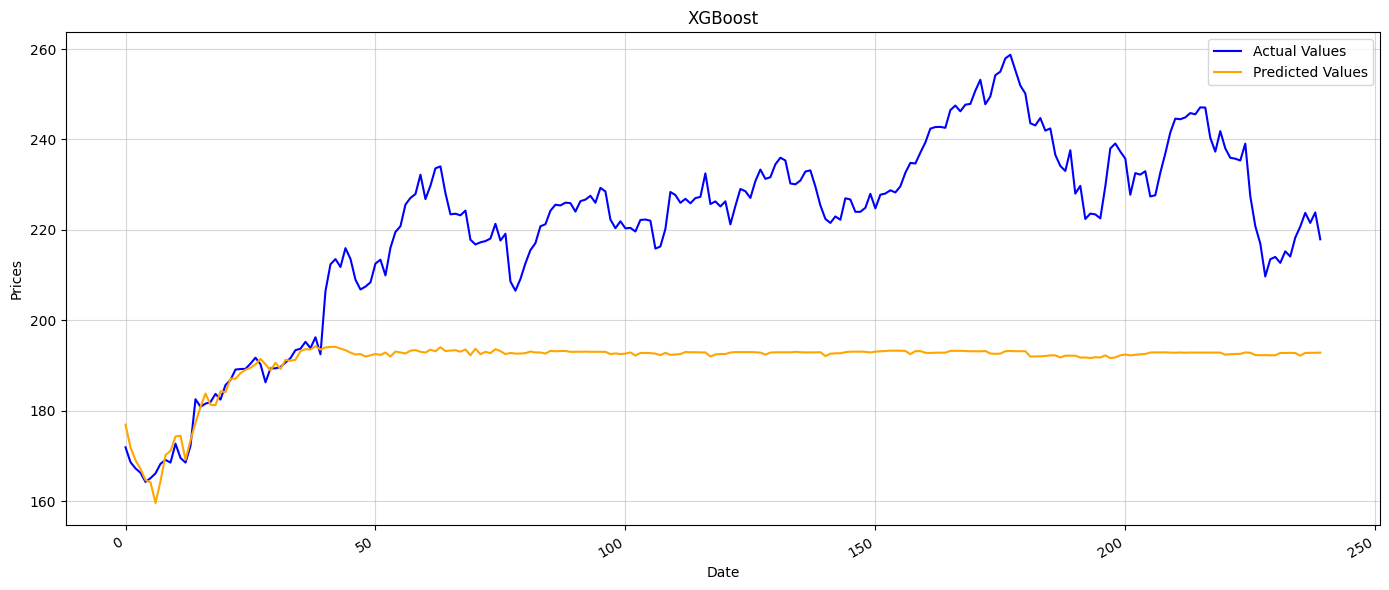

In [15]:
plt.figure(figsize=(14, 6))
plt.plot(y_test, label="Actual Values", color="blue")
plt.plot(y_pred_decision, label="Predicted Values", color="orange")
plt.title("XGBoost")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

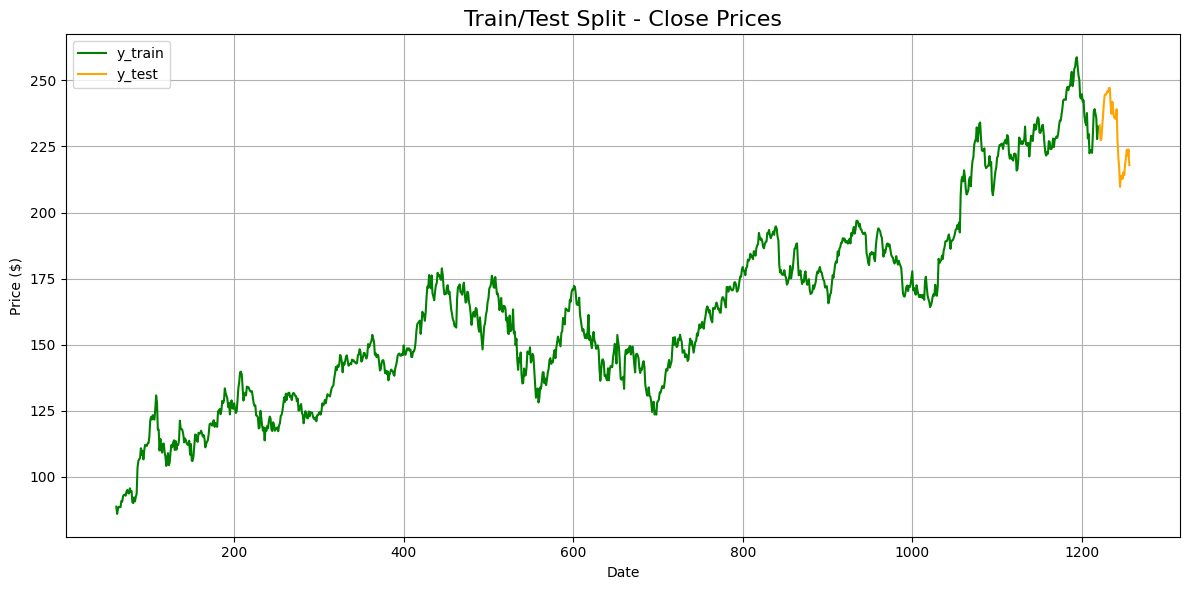

In [32]:
#Increaing train size 90 to 97
train_size = int(len(X) * 0.97) # %97 train %3 test
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='y_train', color='green')
plt.plot(y_test.index, y_test, label='y_test', color='orange')
plt.title("Train/Test Split - Close Prices", fontsize=16)
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=50,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print("Best Params:", random_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Params: {'colsample_bytree': np.float64(0.7358782737814905), 'learning_rate': np.float64(0.2239734361668985), 'max_depth': 3, 'n_estimators': 104, 'subsample': np.float64(0.8683831592708489)}


In [34]:
y_pred_decision = best_model.predict(X_test)
y_test = y_test.to_numpy()
r2_dec= r2_score(y_test, y_pred_decision)
rmse_dec = np.sqrt(mean_squared_error(y_test, y_pred_decision))
mape_dec = mean_absolute_percentage_error(y_test, y_pred_decision)
print(f"R^2 is {r2_dec} \n RMSE is {rmse_dec} \n MAPE is {mape_dec}")

R^2 is 0.8032976500843944 
 RMSE is 5.204191636896338 
 MAPE is 0.016633614509810078


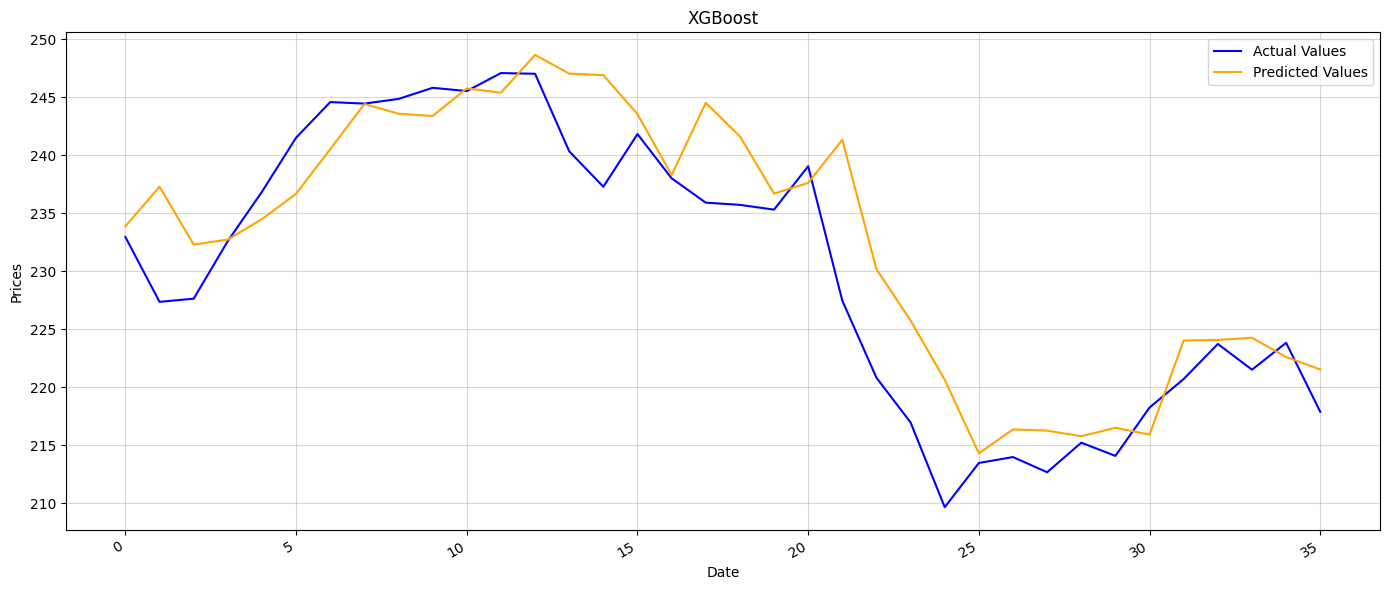

In [57]:
plt.figure(figsize=(14, 6))
plt.plot(y_test, label="Actual Values", color="blue")
plt.plot(y_pred_decision, label="Predicted Values", color="orange")
plt.title("XGBoost")
plt.xlabel("Date")
plt.ylabel("Prices")
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(alpha=0.5)
plt.tight_layout()
plt.show()

In [56]:
best_model.save_model("xgb_model.json")